# DSP HW #5<img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/1200px-University_of_Tehran_logo.svg.png" width=120px style="float: right;"/>
## Ali Sardarian
### UT 2020

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import thinkdsp as dsp
import glob

In [2]:
# Check GPU Availability:
print("GPUs: ", tf.config.experimental.list_physical_devices('GPU'))

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
dataset_batches = 5
training_inputs_list = []
training_labels_list = []
for i in range(dataset_batches):
    data_dict_1 = unpickle("cifar-10-batches-py\\data_batch_"+str(i+1))
    training_inputs_list.extend(data_dict_1[b'data'])
    training_labels_list.extend(data_dict_1[b'labels'])
training_inputs = np.array(training_inputs_list)
# nomalization: (0->1)
training_inputs = training_inputs.reshape((dataset_batches*10000, 32, 32, 3),order='F').swapaxes(1,2)/255.0
# convert labels to one-hot:
training_labels = tf.one_hot(training_labels_list, 10).numpy()
print ("training data shape : ", training_inputs.shape)
print ("training labels shape : ", training_labels.shape)

training data shape :  (50000, 32, 32, 3)
training labels shape :  (50000, 10)


In [5]:
testing_inputs_list = []
testing_labels_list = []
data_dict_2 = unpickle("cifar-10-batches-py\\test_batch")
testing_inputs_list.extend(data_dict_2[b'data'])
testing_labels_list.extend(data_dict_2[b'labels'])
testing_inputs = np.array(testing_inputs_list)
# nomalization: (0->1)
testing_inputs = testing_inputs.reshape((10000, 32, 32, 3),order='F').swapaxes(1,2)/255.0
testing_labels = tf.one_hot(testing_labels_list, 10).numpy() # convert labels to one-hot
print ("testing data shape : ", testing_inputs.shape)
print ("testing labels shape : ", testing_labels.shape)

testing data shape :  (10000, 32, 32, 3)
testing labels shape :  (10000, 10)


In [6]:
label_names = {}
data_dict_3 = unpickle("cifar-10-batches-py\\batches.meta")
label_names = data_dict_3[b'label_names']
print(label_names)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


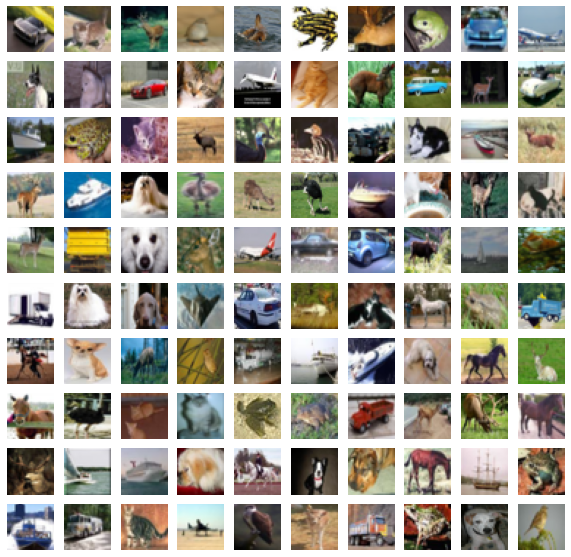

In [8]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(training_inputs[np.random.randint(0, training_inputs.shape[0]-1)])
    plt.axis('off')
plt.show()

In [9]:
model_1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=7, kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=10, activation='softmax')
        ])

In [10]:
model_1.compile(
            optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
            loss= tf.keras.losses.CategoricalCrossentropy(),
            metrics= [tf.keras.metrics.CategoricalAccuracy()]
        )

In [11]:
class MyCustomCallBack(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epochTimes = []
        self.trainLoss = []
        self.validationLoss = []
    def on_train_begin(self,logs = {}):
        self.lastEpochTime = tf.timestamp().numpy() # beginning of training time
    def on_epoch_end(self,epoch,logs = {}):
        self.epochTimes.append(tf.timestamp().numpy() - self.lastEpochTime) # calculate time of this epoch
        self.lastEpochTime = tf.timestamp().numpy() # update for next epoch
        self.trainLoss.append(logs['loss']) # record this epoch train error
        self.validationLoss.append(logs['val_loss']) # record this epoch validation error
    def on_train_end(self,logs = {}):
        # print the average of epochs time:
        print ("\n\n\n\n\nAverage Time of Epochs =", np.mean(np.array(self.epochTimes)), "s")
        # draw error diagram of model:
        plt.plot(self.trainLoss, color='blue', label='train error')
        plt.plot(self.validationLoss, color='red', label='validation error', linestyle='--')
        plt.xlabel('epochs') 
        plt.ylabel('error') 
        plt.title("Notwork's Error Diagram")
        plt.legend(loc=0)
        plt.show()

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 - 8s - loss: 1.6924 - categorical_accuracy: 0.3898 - val_loss: 1.5041 - val_categorical_accuracy: 0.4683
Epoch 2/100
40000/40000 - 6s - loss: 1.5205 - categorical_accuracy: 0.4585 - val_loss: 1.4819 - val_categorical_accuracy: 0.4781
Epoch 3/100
40000/40000 - 6s - loss: 1.4764 - categorical_accuracy: 0.4812 - val_loss: 1.4009 - val_categorical_accuracy: 0.5015
Epoch 4/100
40000/40000 - 6s - loss: 1.4550 - categorical_accuracy: 0.4897 - val_loss: 1.4398 - val_categorical_accuracy: 0.4983
Epoch 5/100
40000/40000 - 6s - loss: 1.4402 - categorical_accuracy: 0.4929 - val_loss: 1.4607 - val_categorical_accuracy: 0.4858
Epoch 6/100
40000/40000 - 6s - loss: 1.4248 - categorical_accuracy: 0.4995 - val_loss: 1.3980 - val_categorical_accuracy: 0.5018
Epoch 7/100
40000/40000 - 6s - loss: 1.4322 - categorical_accuracy: 0.4956 - val_loss: 1.4117 - val_categorical_accuracy: 0.4953
Epoch 8/100
40000/40000 - 6s - loss: 1.4412 - c

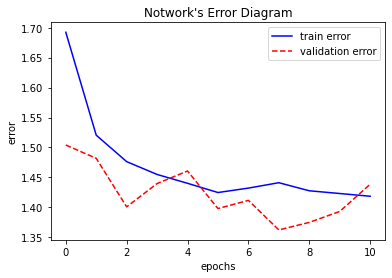

In [12]:
history_1 = model_1.fit(
                x= training_inputs,
                y= training_labels,
                batch_size= 32,
                epochs= 100,
                verbose= 2,
                callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                           MyCustomCallBack()],
                validation_split= 0.2,
                shuffle=True
            )

In [13]:
test_result_1 = model_1.evaluate(
    x= testing_inputs,
    y= testing_labels,
    verbose= 2
    )
print ("\n\nAccuracy on CIFAR-10 Test Data =", test_result_1[1]*100,"%")

10000/10000 - 1s - loss: 1.4506 - categorical_accuracy: 0.5130


Accuracy on CIFAR-10 Test Data = 51.30000114440918 %


# قسمت ب

In [14]:
training_inputs_list_2 = []
training_labels_list_2 = []


for i in range(10):
    files = glob.glob("SpeechRecognition\\TrainSet\\"+str(i)+"\\*.wav")
    for f in files: 
        wave = dsp.read_wave(f)
        wave_array = wave.ys
        spectrum, freqs, t, im = plt.specgram(x=wave_array, Fs=wave.framerate, cmap='jet') # make spectrogram from wave samples
        renderer = plt.gcf().canvas.get_renderer() # current renderer handle
        image = im.make_image(renderer)[0][:,:,:-1] # make image of spectrogram
        plt.close()
        training_inputs_list_2.append(image)
        training_labels_list_2.append(tf.one_hot(i, 10).numpy()) # labeling
        
# shuffle data:
combined_list = list(zip(training_inputs_list_2, training_labels_list_2))
np.random.shuffle(combined_list)
training_inputs_2, training_labels_2 = zip(*combined_list)
training_inputs_2 = np.array(training_inputs_2)
# nomalization: (0->1)
training_inputs_2 = training_inputs_2/255.0
# resize: (32x32)
with tf.device('/CPU:0'):
    training_inputs_2 = tf.image.resize(training_inputs_2, [32,32]).numpy()
training_labels_2 = np.array(training_labels_2)
print ("training data shape : ", training_inputs_2.shape)
print ("training labels shape : ", training_labels_2.shape)

training data shape :  (1900, 32, 32, 3)
training labels shape :  (1900, 10)


In [15]:
testing_inputs_list_2 = []
testing_labels_list_2 = []

for i in range(10):
    files = glob.glob("SpeechRecognition\\TestSet\\"+str(i)+"\\*.wav")
    for f in files: 
        wave = dsp.read_wave(f)
        wave_array = wave.ys
        spectrum, freqs, t, im = plt.specgram(x=wave_array, Fs=wave.framerate, cmap='jet') # make spectrogram from wave samples
        renderer = plt.gcf().canvas.get_renderer() # current renderer handle
        image = im.make_image(renderer)[0][:,:,:-1] # make image of spectrogram
        plt.close()
        testing_inputs_list_2.append(image)
        testing_labels_list_2.append(tf.one_hot(i, 10).numpy()) # labeling
        
testing_inputs_2 = np.array(testing_inputs_list_2)
# nomalization: (0->1)
testing_inputs_2 = testing_inputs_2/255.0
# resize: (32x32)
with tf.device('/CPU:0'):
    testing_inputs_2 = tf.image.resize(testing_inputs_2, [32,32]).numpy()
testing_labels_2 = np.array(testing_labels_list_2)
print ("testing data shape : ", testing_inputs_2.shape)
print ("testing labels shape : ", testing_labels_2.shape)

testing data shape :  (296, 32, 32, 3)
testing labels shape :  (296, 10)


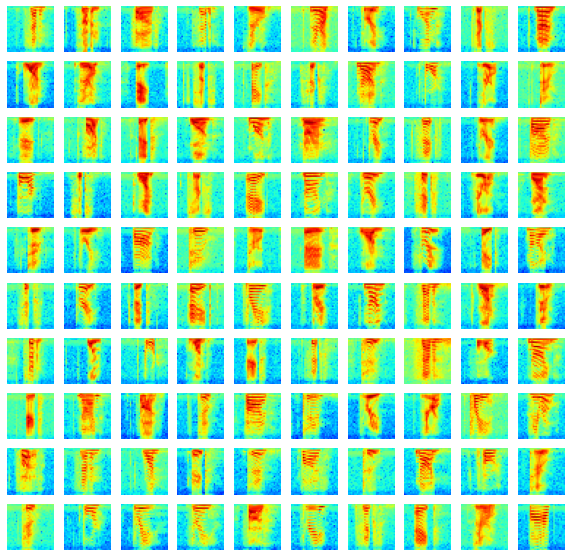

In [16]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(training_inputs_2[i])
    plt.axis('off')
plt.show()

In [17]:
model_2 = tf.keras.Sequential(name='numbers_cnn')
for layer in model_1.layers[:-1]: # exclude final layer
    model_2.add(layer)
model_2.add(tf.keras.layers.Dense(units=10, activation='softmax', name='new_final_layer')) # add a new final layer
model_2.summary()

Model: "numbers_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 7)         196       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 9)         576       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 9)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 9)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1764)              0         
_________________________________________________________________
new_final_layer (Dense)      (None, 10)                17650     
Total params: 18,422
Trainable params: 18,422
Non-trainable params: 0
___________________________________________________

In [18]:
model_2.compile(
            optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
            loss= tf.keras.losses.CategoricalCrossentropy(),
            metrics= [tf.keras.metrics.CategoricalAccuracy()]
        )

Train on 1520 samples, validate on 380 samples
Epoch 1/100
1520/1520 - 4s - loss: 1.2138 - categorical_accuracy: 0.5954 - val_loss: 0.4733 - val_categorical_accuracy: 0.8474
Epoch 2/100
1520/1520 - 0s - loss: 0.3672 - categorical_accuracy: 0.8882 - val_loss: 0.3145 - val_categorical_accuracy: 0.9079
Epoch 3/100
1520/1520 - 0s - loss: 0.2197 - categorical_accuracy: 0.9237 - val_loss: 0.3043 - val_categorical_accuracy: 0.9053
Epoch 4/100
1520/1520 - 0s - loss: 0.1525 - categorical_accuracy: 0.9553 - val_loss: 0.1889 - val_categorical_accuracy: 0.9447
Epoch 5/100
1520/1520 - 0s - loss: 0.1002 - categorical_accuracy: 0.9684 - val_loss: 0.1739 - val_categorical_accuracy: 0.9553
Epoch 6/100
1520/1520 - 0s - loss: 0.0677 - categorical_accuracy: 0.9809 - val_loss: 0.2263 - val_categorical_accuracy: 0.9474
Epoch 7/100
1520/1520 - 0s - loss: 0.0881 - categorical_accuracy: 0.9757 - val_loss: 0.2977 - val_categorical_accuracy: 0.9079
Epoch 8/100
1520/1520 - 0s - loss: 0.0561 - categorical_accuracy

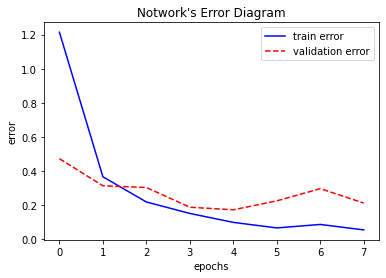

In [19]:
history_2 = model_2.fit(
                x= training_inputs_2,
                y= training_labels_2,
                batch_size= 32,
                epochs= 100,
                verbose= 2,
                callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                           MyCustomCallBack()],
                validation_split= 0.2,
                shuffle=True
            )

In [20]:
test_result_2 = model_2.evaluate(
    x= testing_inputs_2,
    y= testing_labels_2,
    verbose= 2
    )
print ("\n\nAccuracy on Numbers Test Data =", test_result_2[1]*100,"%")

296/296 - 0s - loss: 0.1855 - categorical_accuracy: 0.9358


Accuracy on Numbers Test Data = 93.58108043670654 %


# قسمت پ

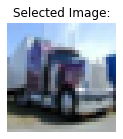

In [339]:
# select a random test input from CIFAR-10:
random_index = np.random.randint(0, testing_inputs.shape[0]-1)
selected_image = testing_inputs[random_index]
selected_image = np.expand_dims(selected_image, axis=0)
plt.figure(figsize=(2,2))
plt.imshow(selected_image[0])
plt.axis('off')
plt.title('Selected Image:') 
plt.show()

In [405]:
label_names[np.argmax(model_1.predict(selected_image))] # TEST

b'truck'

In [422]:
conv2d_outputs = model_1.layers[0](selected_image).numpy()[0]
conv2d_outputs = conv2d_outputs/conv2d_outputs.max() # normalize
print("Conv2D outputs shape:",conv2d_outputs.shape)
conv2d_kernels = model_1.layers[0].get_weights()[0]
conv2d_kernels = conv2d_kernels/conv2d_kernels.max() # normalize
print("Conv2D kernels shape:",conv2d_kernels.shape)

Conv2D outputs shape: (30, 30, 7)
Conv2D kernels shape: (3, 3, 3, 7)


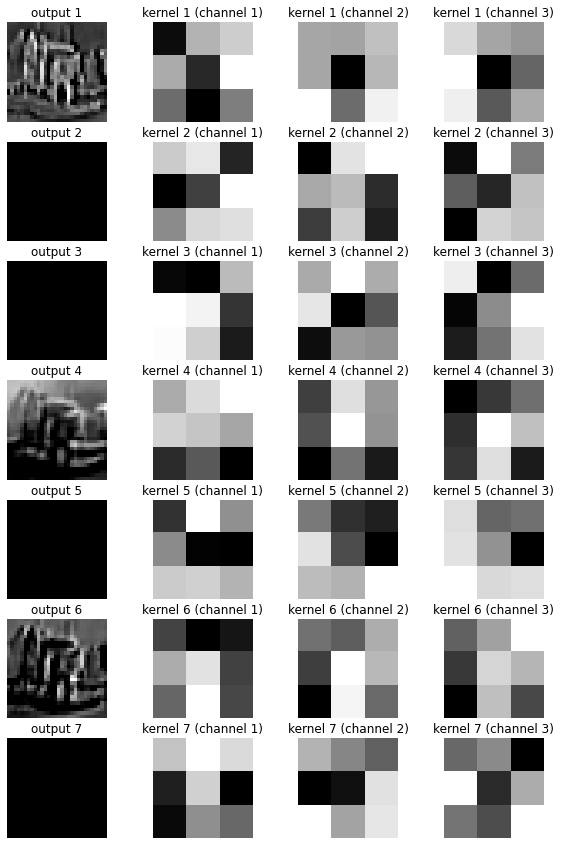

In [423]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    if (i%4 == 0):
        # output image:
        ax.imshow(conv2d_outputs[:,:,int(i/4)], cmap = 'gray', interpolation='nearest')
        ax.set_title("output "+str(int(i/4)+1))
    else:
        # kernel image:
        ax.imshow(conv2d_kernels[:,:,(i%4)-1,int(i/4)], cmap = 'gray', interpolation='nearest')
        ax.set_title("kernel "+str(int(i/4)+1)+" (channel "+str((i%4))+")")
    ax.axis('off')
plt.show()

# قسمت ت

In [380]:
model_1_improved = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(filters=7, kernel_size=(5,5), activation='relu', input_shape=(32, 32, 3)),
                    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
                    tf.keras.layers.Dropout(rate=0.25),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=10, activation='softmax')
                ])

In [381]:
model_1_improved.compile(
                    optimizer= tf.keras.optimizers.Adam(learning_rate= pow(10,-4)),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics= [tf.keras.metrics.CategoricalAccuracy()]
                )

Epoch 00094: early stopping





Average Time of Epochs = 5.834999979810512 s


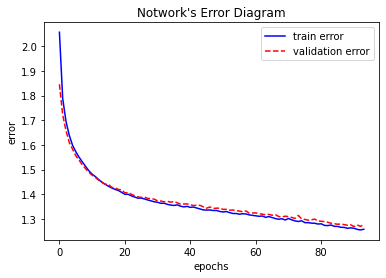

In [382]:
model_1_improved.fit(
                    x= training_inputs,
                    y= training_labels,
                    batch_size= 32,
                    epochs= 1000,
                    verbose= 0,
                    callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                               MyCustomCallBack()],
                    validation_split= 0.2,
                    shuffle=True
                )

In [385]:
model_2_improved = tf.keras.Sequential(name='numbers_cnn_improved')
for layer in model_1_improved.layers[:-1]: # exclude final layer
    model_2_improved.add(layer)
model_2_improved.add(tf.keras.layers.Dense(units=10, activation='softmax', name='new_final_layer_2')) # add a new final layer
model_2_improved.summary()

Model: "numbers_cnn_improved"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 7)         532       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 7)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 7)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1372)              0         
_________________________________________________________________
new_final_layer_2 (Dense)    (None, 10)                13730     
Total params: 14,262
Trainable params: 14,262
Non-trainable params: 0
_________________________________________________________________


In [386]:
model_2_improved.compile(
                    optimizer= tf.keras.optimizers.Adam(learning_rate= pow(10,-4)),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics= [tf.keras.metrics.CategoricalAccuracy()]
                )

Epoch 00007: early stopping





Average Time of Epochs = 0.23138025828770228 s


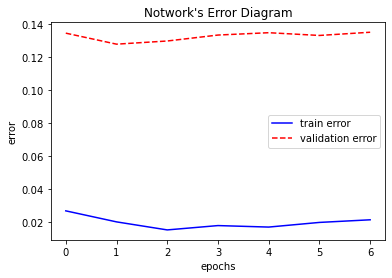

In [414]:
model_2_improved.fit(
                    x= training_inputs_2,
                    y= training_labels_2,
                    batch_size= 32,
                    epochs= 1000,
                    verbose= 0,
                    callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                               MyCustomCallBack()],
                    validation_split= 0.2,
                    shuffle=True
                )

In [415]:
test_result_2_improved = model_2_improved.evaluate(
    x= testing_inputs_2,
    y= testing_labels_2,
    verbose= 2
    )
print ("\n\nNew Accuracy on Numbers Test Data =", test_result_2_improved[1]*100,"%")

296/296 - 0s - loss: 0.1587 - categorical_accuracy: 0.9561


New Accuracy on Numbers Test Data = 95.60810923576355 %
